In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import seaborn as sns

resultado_anterior = 0
maximo = 0

In [114]:
def modelfit(model, features, labels, usarCrossValidation=True, cv_folds=5, early_stopping_rounds=50):
    if usarCrossValidation:
        parametros = model.get_xgb_params()
        dmatrix = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(parametros, dmatrix, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds, as_pandas=True)
        model.set_params(n_estimators=cvresult.shape[0])
    
    model.fit(features, labels,eval_metric='auc')
    return cvresult
    
def obtener_marca(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(prefix + modelo.split()[0])
    return r

def obtener_browser(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append(np.NaN)
        else:
            r.append(prefix + modelo.split()[0])
    return r

def obtenerRes(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append(np.NaN)
        else:
            r.append(prefix + modelo.split("x")[0])
    return r

### Lectura csv

In [3]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

### Creacion de features

In [66]:
#
###                               CREACION DF PREDICTOR
#

dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#
###                               FILTRADO DE FECHAS
#

antesDeMayo = df.loc[df['timestamp'] < pd.to_datetime('01-05-2018')]
ult30Dias = df.loc[(df['timestamp'] > pd.to_datetime('01-05-2018'))]# & (df['timestamp'] > pd.to_datetime('15-05-2018'))]
ult15Dias = df.loc[(df['timestamp'] > pd.to_datetime('15-05-2018'))]# & (df['timestamp'] > pd.to_datetime('25-05-2018'))]
ult5Dias = df.loc[(df['timestamp'] > pd.to_datetime('25-05-2018'))]# & (df['timestamp'] > pd.to_datetime('31-05-2018'))]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]

#
###                               CREACION DE FEATURES
#

#
##  POR EVENTO


#  CHECKOUTS

checkoutsPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaAntesDeMayo.columns = ['checkoutsPorPersonaAntesDeMayo']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']


dfPredictor = dfPredictor.join(checkoutsPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  CONVERSIONES

conversionesPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
conversionesPorPersonaAntesDeMayo.columns = ['conversionesPorPersonaAntesDeMayo']

conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

dfPredictor = dfPredictor.join(conversionesPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  VISITAS

visitasUlt15DiasPorPersona = ult15Dias.loc[ult15Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt15DiasPorPersona.columns = ['CantVisitasUlt15Dias']

visitasUlt5DiasPorPersona = ult5Dias.loc[ult5Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt5DiasPorPersona.columns = ['CantVisitasUlt5Dias']

visitasUltDiaPorPersona = ultDia.loc[ultDia['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUltDiaPorPersona.columns = ['CantVisitasUltDia']

dfPredictor = dfPredictor.join(visitasUlt15DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUlt5DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUltDiaPorPersona, how = 'left', on = 'person').fillna(value = 0)


#  VIEWED PRODUCT

viewedProductPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt15Dias.columns = ['viewedProductUlt15Dias']

viewedProductPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt5Dias.columns = ['viewedProductUlt5Dias']

viewedProductPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUltDia.columns = ['viewedProductUltDia']

dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### POR CANAL DE ORIGEN

visitasUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'visited site']
visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

#  PAGO

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)


#  ORGANIC

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)


#  DIRECT
directUlt30Dias = visitasUlt30Dias.loc[visitasUlt30Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt30Dias.columns = ['CanalDirectoUlt30Dias']

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']
#directUlt15Dias['CanalDirectoUlt15Dias'] = 1

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

dfPredictor = dfPredictor.join(directUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)


#  REFERRAL

referralUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt15Dias.columns = ['CanalReferidoUlt15Dias']

referralUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt5Dias.columns = ['CanalReferidoUlt5Dias']

referralUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUltDia.columns = ['CanalReferidoUltDia']

dfPredictor = dfPredictor.join(referralUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUltDia, how = 'left', on = 'person').fillna(value = 0)


#  SOCIAL

socialUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt15Dias.columns = ['CanalSocialUlt15Dias']

socialUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt5Dias.columns = ['CanalSocialUlt5Dias']

socialUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Social']['person'].value_counts().to_frame()
socialUltDia.columns = ['CanalSocialUltDia']

dfPredictor = dfPredictor.join(socialUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUltDia, how = 'left', on = 'person').fillna(value = 0)


#  EMAIL

emailUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt15Dias.columns = ['CanalEmailUlt15Dias']

emailUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt5Dias.columns = ['CanalEmailUlt5Dias']

emailUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Email']['person'].value_counts().to_frame()
emailUltDia.columns = ['CanalEmailUltDia']

dfPredictor = dfPredictor.join(emailUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### FEATURES AVANZADOS

#  CANTIDAD DE CHECKOUTS POR MARCA

#marcas = {'Samsung':'Samsung', 'Motorola':'Motorola', 'iPhone':'iPhone', 'LG':'LG', 'Sony':'Sony', 'Lenovo':'Lenovo','iPad':'iPad', 'Quantum':'Quantum', 'Asus':'Asus'}
prefijo = "total_checks_"
#marcas = {marca: prefijo + nombreFeature for marca, nombreFeature in marcas.items()}

total_checks = df.loc[df["event"]=="checkout"].copy()
total_checks["Marca"] = obtener_marca(total_checks["model"],prefijo)
#total_checks = total_checks.loc[(total_checks["Marca"]==marcas["iPhone"])|(total_checks["Marca"]==marcas["Samsung"])]
total_checks["contador"] = 1
total_checks=total_checks.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_checks, how = 'left', on = 'person').fillna(value = 0)

prefijo = "total_views_"
total_views = ult30Dias.loc[ult30Dias["event"]=="viewed product"].copy()
total_views["Marca"] = obtener_marca(total_views["model"],prefijo)
#total_views = total_views.loc[(total_views["Marca"]==marcas["iPhone"])|(total_views["Marca"]==marcas["Samsung"])]
total_views["contador"] = 1
total_views=total_views.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_views, how = 'left', on = 'person').fillna(value = 0)

## CANTIDAD DE BUSQUEADAS
name_feature1 = "cant_searchs_ult_30"
name_feature2 = "busco_ult_30"
cant_search = ult30Dias.loc[ult30Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_15"
name_feature2 = "busco_ult_15"
cant_search = ult15Dias.loc[ult15Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_5"
name_feature2 = "busco_ult_5"
cant_search = ult5Dias.loc[ult5Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_total"
name_feature2 = "busco_total"
cant_search = df.loc[df["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

# Primer ingreso
primer_ingreso = df.groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primerIngreso']
primer_ingreso['primerIngreso'] = primer_ingreso['primerIngreso'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultimo ingreso
ultimo_ingreso = df.groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimoIngreso']
ultimo_ingreso['ultimoIngreso'] = ultimo_ingreso['ultimoIngreso'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# Primer checkout
primer_ingreso = df[df['event'] == 'checkout'].groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primerCheckout']
primer_ingreso['primerCheckout'] = primer_ingreso['primerCheckout'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultimo checkout
ultimo_ingreso = df[df['event'] == 'checkout'].groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimoCheckout']
ultimo_ingreso['ultimoCheckout'] = ultimo_ingreso['ultimoCheckout'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# Primera conversion
primer_ingreso = df[df['event'] == 'conversion'].groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primeraConversion']
primer_ingreso['primeraConversion'] = primer_ingreso['primeraConversion'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultima conversion
ultimo_ingreso = df[df['event'] == 'conversion'].groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimaConversion']
ultimo_ingreso['ultimaConversion'] = ultimo_ingreso['ultimaConversion'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# region desde donde mas visita
region = df.loc[(df["event"] == "visited site") & (df['country'] == 'Brazil'), ['person','region']]
region = region
region["count"] =1
region = region.groupby(["person","region"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del region["count"]
region.set_index("person",inplace=True)
regionesNoBrasil = df.loc[(df["event"] == "visited site") & (df['country'] != 'Brazil')]['region'].unique()
region['region'].cat.remove_categories(regionesNoBrasil,inplace=True)
region = pd.get_dummies(region['region'])
dfPredictor = dfPredictor.join(region, how = 'left', on = 'person').fillna(value = 0)

# CONDICION

condicion = df.groupby('person')['condition'].value_counts().to_frame()
condicion.columns = ['cant']
condicion = condicion.reset_index()
condicion = condicion.pivot(columns='condition', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dfPredictor = dfPredictor.join(condicion, how = 'left', on = 'person').fillna(value = 0)

# DISPOSITIVO
# Todo
dispositivo = df.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person').fillna(value = 0)
#30 dias
dispositivo = ult30Dias.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person', rsuffix="Ult30Dias").fillna(value = 0)
#15 dias
dispositivo = ult15Dias.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person', rsuffix="Ult15Dias").fillna(value = 0)
#5 dias
dispositivo = ult5Dias.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person', rsuffix="Ult5Dias").fillna(value = 0)
#1 dia
dispositivo = ultDia.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person', rsuffix="UltDia").fillna(value = 0)


# CAMPAIGN SORUCE
# Todo
dispositivo = df.groupby('person')['campaign_source'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='campaign_source', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person').fillna(value = 0)

# BROWSER VERSION
df["browser"] = obtener_browser(df['browser_version'])
browser = df.loc[df["browser"].notna(),["person", "browser"]].copy()
browser = browser.groupby('person')['browser'].value_counts().to_frame()
browser.columns = ['cant']
browser = browser.reset_index()
browser = browser.pivot(columns='browser', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dfPredictor = dfPredictor.join(browser, how = 'left', on = 'person', rsuffix="Browser").fillna(value = 0)


# SCREEN RESOLUTION

df["screenRes"] = obtenerRes(df['screen_resolution'])
screen = df.loc[df["screenRes"].notna(),["person", "screenRes"]].copy()
screen["screenRes"] = screen["screenRes"].astype(int)
screen["screenRes"] = np.where(screen["screenRes"].between(0,319), 200, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(320,359), 340, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(360,400), 380, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(401,600), 500, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(601,1000), 1000, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(1000,100000), 2000, screen["screenRes"])

screen = screen.groupby('person')['screenRes'].value_counts().to_frame()
screen.columns = ['cant']
screen = screen.reset_index()
screen["screenRes"] = screen["screenRes"].astype(str)
screen = screen.pivot(columns='screenRes', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dfPredictor = dfPredictor.join(screen, how = 'left', on = 'person').fillna(value = 0)

# Pais
pais = df.loc[df["event"] == "visited site", ['person','country']]
pais["count"] =1
pais = pais.groupby(["person","country"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del pais["count"]
pais["esDeBrasil"] = pais["country"] == "Brazil"
del pais["country"]
pais.set_index("person",inplace=True)
dfPredictor = dfPredictor.join(pais, how = 'left', on = 'person')
dfPredictor["esDeBrasil"].fillna(value = False,inplace=True)

#vieron
vieron_celular = df.loc[(df["event"] == "viewed product") & (df["model"] == "Samsung Galaxy J5"),["person"]]
vieron_celular["vieron_celular"] = 1
vieron_celular.set_index("person",inplace=True)
vieron_celular = vieron_celular[~vieron_celular.index.duplicated(keep='first')]
dfPredictor = dfPredictor.join(vieron_celular, how = 'left', on = 'person')
dfPredictor["vieron_celular"].fillna(value = 0,inplace=True)

### TEEEEEEEEEEST Cuantas veces hizo checkout de los 20 celus mas visitados
view_products = ult15Dias.loc[ult15Dias["event"] == "checkout",["model"]].copy()
view_products["Visitas"] = 1
phones20view = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(4).index.tolist()
checkouts = df.loc[df["event"]=="checkout",["person","model"]].copy()
def estaDentroDe(serie,lista):
    r = []
    for i in serie:
        if i in lista:
            r.append(True)
        else:
            r.append(False)
    return r
checkouts["model"] = estaDentroDe(checkouts["model"],phones20view)
checkouts= checkouts.groupby("person").agg("sum")
dfPredictor = dfPredictor.join(checkouts, how = 'left', on = 'person')
dfPredictor["model"].fillna(value = 0,inplace=True)

dfPredictor['regiones'] = dfPredictor['Ceara'] + dfPredictor['Santa Catarina'] + dfPredictor['Rio de Janeiro'] + dfPredictor['Sao Paulo'] +  dfPredictor['Rio Grande do Norte'] + dfPredictor['Rio Grande do Sul'] + dfPredictor['Maranhao'] 

### Agregado y quitado de features y cambio de disposicion de las columnas

In [67]:
list(dfPredictor.columns)

['checkoutsPorPersonaAntesDeMayo',
 'checkoutsUlt30Dias',
 'checkoutsUlt15Dias',
 'checkoutsUlt5Dias',
 'checkoutsUltDia',
 'conversionesPorPersonaAntesDeMayo',
 'conversionesUlt30Dias',
 'conversionesUlt15Dias',
 'conversionesUlt5Dias',
 'conversionesUltDia',
 'CantVisitasUlt15Dias',
 'CantVisitasUlt5Dias',
 'CantVisitasUltDia',
 'viewedProductUlt15Dias',
 'viewedProductUlt5Dias',
 'viewedProductUltDia',
 'CanalPagoUlt15Dias',
 'CanalPagoUlt5Dias',
 'CanalPagoUltDia',
 'CanalOrganicoUlt15Dias',
 'CanalOrganicoUlt5Dias',
 'CanalOrganicoUltDia',
 'CanalDirectoUlt30Dias',
 'CanalDirectoUlt15Dias',
 'CanalDirectoUlt5Dias',
 'CanalDirectoUltDia',
 'CanalReferidoUlt15Dias',
 'CanalReferidoUlt5Dias',
 'CanalReferidoUltDia',
 'CanalSocialUlt15Dias',
 'CanalSocialUlt5Dias',
 'CanalSocialUltDia',
 'CanalEmailUlt15Dias',
 'CanalEmailUlt5Dias',
 'CanalEmailUltDia',
 'total_checks_Asus',
 'total_checks_LG',
 'total_checks_Lenovo',
 'total_checks_Motorola',
 'total_checks_Quantum',
 'total_checks_S

In [110]:
# Cambio disposicion de columnas ya que esta presenta mejor resultado
# Cuando se agregue una feature nueva, agregar el nombre de columna a esta lista para que surta efecto
# Reordenar en la lista cambia el orden de las columnas en el predictor

cols = [
'Computer', 'Smartphone', 'Tablet',# 'Unknown',
'ComputerUlt30Dias',
'SmartphoneUlt30Dias',
'TabletUlt30Dias',
#'UnknownUlt30Dias',
'ComputerUlt15Dias',
'SmartphoneUlt15Dias',
'TabletUlt15Dias',
#'UnknownUlt15Dias',
#'ComputerUlt5Dias',
#'SmartphoneUlt5Dias',
#'TabletUlt5Dias',
#'UnknownUlt5Dias',
#'ComputerUltDia',
#'SmartphoneUltDia',
#'TabletUltDia',
#'UnknownUltDia',    
'Facebook',
 'FacebookAds',
# 'FacebookSocial',
 #'MARKETING SOCIAL',
 #'afiliado',
 'afilio',
 'bing',
 'blog',
 'buscape',
 'criteo',
 'datacrush',
 'emblue',
 #'gizmodo',
 'google',
# 'indexa',
 'manifest',
 #'mercadopago',
# 'onsite',
# 'rakuten',
 'rtbhouse',
 'voxus',
# 'yotpo',
 'zanox',
    
#'Android',
# 'BingPreview',
# 'BlackBerry',
 'Chrome',
 'Chromium',
 'Edge',
 'FacebookBrowser',
 'Firefox',
 'IE',
 #'K-Meleon',
# 'Maxthon',
 'Mobile',
 'Opera',
# 'Other',
 #'Pinterest',
# 'Puffin',
 'Safari',
 'Samsung',
# 'UC',
 #'Vivaldi',
 #'WebKit',
# 'Yandex',

#'200',
    '2000', '340', '380', '500',
'primerIngreso',
'ultimoIngreso',
'primerCheckout',
'ultimoCheckout',
'primeraConversion',
'ultimaConversion',
'CanalDirectoUlt15Dias',
'checkoutsUlt15Dias',
'checkoutsUlt30Dias',
'checkoutsUlt5Dias',
'checkoutsUltDia',

'Bom', 
'Bom - Sem Touch ID', 
'Excelente', 
'Muito Bom',
'Novo',
#'conversionesUlt30Dias',
'conversionesUlt15Dias',
#'conversionesUlt5Dias',
#'conversionesUltDia',
'CantVisitasUlt15Dias',
#'CantVisitasUlt5Dias',
#'CantVisitasUltDia',
'viewedProductUlt15Dias',
'viewedProductUlt5Dias',
#'viewedProductUltDia',
#'CanalOrganicoUlt5Dias',
'CanalDirectoUlt5Dias',
'CanalDirectoUltDia',
#'CanalReferidoUlt15Dias',
'CanalReferidoUlt5Dias',
#'CanalReferidoUltDia',
'cant_searchs_ult_15',
#'CanalPagoUlt5Dias',
'total_views_Samsung',
'total_views_iPhone',
'total_views_Motorola',
#'total_checks_Samsung',
#'total_checks_iPhone',
#'total_checks_Motorola',
#'CanalDirectoUlt30Dias',
#'total_views_Asus',
'total_views_LG',
#'total_views_Lenovo',
#'total_views_Quantum',
#'total_views_Sony',
#'total_views_iPad',
#'total_checks_Asus',
#'total_checks_LG',
#'total_checks_Lenovo',
#'total_checks_Quantum',
#'total_checks_Sony',
#'checkoutsPorPersonaAntesDeMayo',
#'conversionesPorPersonaAntesDeMayo',
#'CanalPagoUlt15Dias',
#'CanalPagoUltDia',
'CanalOrganicoUlt15Dias',
#'CanalOrganicoUltDia',
'CanalSocialUlt15Dias',
'CanalSocialUlt5Dias',
#'CanalSocialUltDia',
'CanalEmailUlt15Dias',
#'CanalEmailUlt5Dias',
#'CanalEmailUltDia',
#'cant_searchs_ult_30',
#'busco_ult_30',
#'busco_ult_15',
'cant_searchs_ult_5',
#'busco_ult_5', 
#'cant_searchs_total',
#"busco_total",
#'esDeBrasil',
#"vieron_celular",
#'Acre',
#'Alagoas', 'Amapa', 'Amazonas', 'Bahia',
#'Ceara',
#'Espirito Santo', 'Federal District', 'Goias',
#'Maranhao',
#'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Para', 'Parana',
#'Paraíba', 'Pernambuco', 'Piaui',
#'Rio Grande do Norte',
#'Rio Grande do Sul',
#'Rio de Janeiro',
#'Rondonia', 'Roraima',
#'Santa Catarina',
#'Sao Paulo',
#'Sergipe', 'Tocantins'
'regiones',
]

# Separo los labels locales
dfPredictorIndexado=dfPredictor.reindex(columns=cols)
#dfPredictorIndexado = dfPredictorIndexado.join(one_hot, how = 'left', on = 'person')
dfPredictorLocal = dfPredictorIndexado.join(labels, how = 'inner')

### Entrenamiento del modelo

In [130]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

modelo = xgb.XGBRegressor(
 #booster='dart',
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=8,
 gamma=0.1,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=18.8,

 #sample_type='weighted',
 #rate_drop=0.1,
 #skip_dropout=0.5,
 random_state=272)

result_pd = modelfit(modelo, X_train, y_train, early_stopping_rounds=30)

predsa = modelo.predict(X_test)
predsa[predsa < 0 ] = 0
predsa[predsa > 1] = 1
resultado = roc_auc_score(y_test, predsa)
print(resultado)
print("Vario: {} con respecto al anterior".format(resultado-resultado_anterior))
if (maximo == resultado):
    print(" Maximo igualado")
else:
    print("Maximo anterior {}".format(maximo))
if resultado>maximo:
    print("Nuevo MAXIMO : {}".format(resultado-maximo))
    maximo = resultado
resultado_anterior = resultado

[0]	train-auc:0.854333+0.0027046	test-auc:0.84205+0.00897343
[1]	train-auc:0.854802+0.00320675	test-auc:0.842135+0.00904347
[2]	train-auc:0.854888+0.00331834	test-auc:0.842321+0.00920481
[3]	train-auc:0.85637+0.00221515	test-auc:0.842304+0.0092148
[4]	train-auc:0.856366+0.00221036	test-auc:0.842215+0.00914489
[5]	train-auc:0.856445+0.00226774	test-auc:0.842278+0.00918761
[6]	train-auc:0.857654+0.0040792	test-auc:0.843672+0.0107244
[7]	train-auc:0.85915+0.00383352	test-auc:0.844184+0.0118763
[8]	train-auc:0.861704+0.00435689	test-auc:0.846205+0.0115495
[9]	train-auc:0.861978+0.0045374	test-auc:0.846585+0.0118743
[10]	train-auc:0.862269+0.00486778	test-auc:0.846693+0.0122161
[11]	train-auc:0.862507+0.00497759	test-auc:0.846775+0.0119999
[12]	train-auc:0.862986+0.00482583	test-auc:0.847145+0.0117625
[13]	train-auc:0.86299+0.00482886	test-auc:0.847135+0.0117531
[14]	train-auc:0.86333+0.00493139	test-auc:0.847591+0.0118429
[15]	train-auc:0.863343+0.00495995	test-auc:0.84761+0.0118483
[16]	t

[129]	train-auc:0.875318+0.00318949	test-auc:0.861025+0.00845016
[130]	train-auc:0.875342+0.00324796	test-auc:0.861064+0.00843422
[131]	train-auc:0.875369+0.00327428	test-auc:0.861021+0.00843931
[132]	train-auc:0.875388+0.00323625	test-auc:0.861079+0.00839422
[133]	train-auc:0.875401+0.00330077	test-auc:0.86095+0.00821541
[134]	train-auc:0.875489+0.00323721	test-auc:0.861224+0.00846184
[135]	train-auc:0.875438+0.00328362	test-auc:0.860975+0.00825276
[136]	train-auc:0.875625+0.00327756	test-auc:0.861034+0.00828233
[137]	train-auc:0.875627+0.00323544	test-auc:0.861092+0.00825007
[138]	train-auc:0.875741+0.0031826	test-auc:0.861164+0.0083659
[139]	train-auc:0.875791+0.00322157	test-auc:0.861065+0.00827744
[140]	train-auc:0.875837+0.00311716	test-auc:0.861211+0.00837704
[141]	train-auc:0.875837+0.00309458	test-auc:0.861302+0.00839759
[142]	train-auc:0.87588+0.00309794	test-auc:0.861323+0.00839403
[143]	train-auc:0.875936+0.00309434	test-auc:0.861337+0.0084043
[144]	train-auc:0.875945+0.003

### Creacion del submit para kaggle

In [112]:
modelfit(modelo, X, y, early_stopping_rounds=50)
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictorIndexado.join(kaggle, how = 'inner')
predsSubmit = modelo.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

[0]	train-auc:0.858026+0.00341642	test-auc:0.845492+0.0116576
[1]	train-auc:0.858063+0.00341425	test-auc:0.845657+0.0118006
[2]	train-auc:0.858354+0.00304148	test-auc:0.846219+0.0119772
[3]	train-auc:0.858648+0.00283874	test-auc:0.846253+0.012
[4]	train-auc:0.858941+0.00248022	test-auc:0.846148+0.0119594
[5]	train-auc:0.858906+0.00251834	test-auc:0.846314+0.012025
[6]	train-auc:0.85946+0.00247641	test-auc:0.846359+0.0120149
[7]	train-auc:0.859459+0.00247794	test-auc:0.846358+0.0120143
[8]	train-auc:0.860738+0.0033436	test-auc:0.847672+0.0129528
[9]	train-auc:0.860771+0.00316316	test-auc:0.84779+0.0128706
[10]	train-auc:0.862367+0.00460793	test-auc:0.850432+0.00924954
[11]	train-auc:0.862711+0.00446999	test-auc:0.85079+0.00945862
[12]	train-auc:0.863735+0.00431538	test-auc:0.852124+0.00934102
[13]	train-auc:0.863961+0.00444098	test-auc:0.852142+0.00942507
[14]	train-auc:0.863856+0.00437523	test-auc:0.852085+0.00936396
[15]	train-auc:0.865469+0.00316163	test-auc:0.854181+0.0103055
[16]	t

[130]	train-auc:0.880534+0.00205978	test-auc:0.86635+0.00996263
[131]	train-auc:0.880597+0.00204642	test-auc:0.866438+0.009794
[132]	train-auc:0.880642+0.00201972	test-auc:0.866507+0.00968821
[133]	train-auc:0.880785+0.00214901	test-auc:0.866482+0.00961508
[134]	train-auc:0.880856+0.00217475	test-auc:0.866532+0.00960206
[135]	train-auc:0.880874+0.00214477	test-auc:0.866575+0.00960973
[136]	train-auc:0.880912+0.0021925	test-auc:0.866495+0.00957025
[137]	train-auc:0.880961+0.0021836	test-auc:0.86656+0.00959006
[138]	train-auc:0.880988+0.00216638	test-auc:0.866605+0.00955057
[139]	train-auc:0.881115+0.00215416	test-auc:0.866676+0.00956336
[140]	train-auc:0.881126+0.00212891	test-auc:0.866702+0.00955775
[141]	train-auc:0.881172+0.00213968	test-auc:0.86672+0.00958265
[142]	train-auc:0.881217+0.0021277	test-auc:0.866722+0.00957295
[143]	train-auc:0.881321+0.00216707	test-auc:0.866774+0.00957561
[144]	train-auc:0.881397+0.00216283	test-auc:0.866734+0.00966835
[145]	train-auc:0.881447+0.002116

[257]	train-auc:0.88837+0.00176805	test-auc:0.871112+0.00926747
[258]	train-auc:0.888416+0.00174659	test-auc:0.871146+0.00919763
[259]	train-auc:0.888509+0.00177559	test-auc:0.871173+0.00918335
[260]	train-auc:0.888542+0.00175169	test-auc:0.871147+0.00927166
[261]	train-auc:0.888595+0.00174048	test-auc:0.871179+0.00928725
[262]	train-auc:0.888671+0.00173638	test-auc:0.871187+0.00920882
[263]	train-auc:0.888727+0.0017357	test-auc:0.871216+0.00926271
[264]	train-auc:0.88881+0.00175522	test-auc:0.871183+0.00927268
[265]	train-auc:0.888859+0.00176021	test-auc:0.871205+0.00926235
[266]	train-auc:0.888937+0.00175483	test-auc:0.871267+0.00926019
[267]	train-auc:0.889035+0.00177331	test-auc:0.871275+0.00926887
[268]	train-auc:0.889123+0.00176675	test-auc:0.87133+0.00920686
[269]	train-auc:0.889154+0.00176257	test-auc:0.871356+0.00918702
[270]	train-auc:0.889244+0.00173685	test-auc:0.871373+0.00919646
[271]	train-auc:0.889324+0.00173076	test-auc:0.87143+0.00920412
[272]	train-auc:0.889363+0.001

### Random forest para feature importance

[Text(0,0.5,'Feature'), Text(0.5,0,'Importancia')]

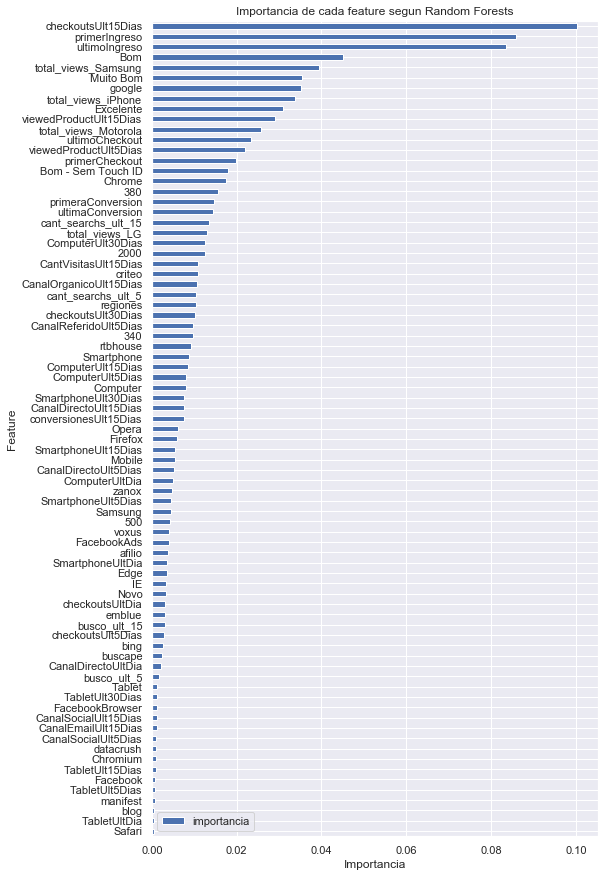

In [90]:
from sklearn.ensemble import RandomForestRegressor

sns.set(rc={'figure.figsize':(8,15)})
names = X.columns
rf = RandomForestRegressor(
    random_state=123,
    n_estimators=400,
    min_samples_split=3
)
rf.fit(X_train.values, y_train.values.ravel())
impor = np.vstack((names, rf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False).iloc[::-1]
ax = imporDf.plot(kind='barh')
ax.set_title("Importancia de cada feature segun Random Forests")
ax.set(xlabel="Importancia", ylabel="Feature")

In [37]:
list(df.columns)

['timestamp',
 'event',
 'person',
 'url',
 'sku',
 'model',
 'condition',
 'storage',
 'color',
 'skus',
 'search_term',
 'staticpage',
 'campaign_source',
 'search_engine',
 'channel',
 'new_vs_returning',
 'city',
 'region',
 'country',
 'device_type',
 'screen_resolution',
 'operating_system_version',
 'browser_version',
 'screenRes']

In [63]:
df["browser"] = obtener_browser(df["browser_version"])
df["browser"].value_counts()

Chrome         173833
Mobile           7730
Firefox          7004
Samsung          4809
Facebook         3064
Edge             2752
Opera            1600
IE               1550
Android           946
UC                311
Safari            226
BlackBerry         73
Chromium           63
Puffin             26
Vivaldi            25
Yandex             24
Pinterest          13
Other               9
Maxthon             6
WebKit              3
K-Meleon            1
BingPreview         1
Name: browser, dtype: int64

In [127]:
result_pd.iloc[-1]["test-auc-mean"]

0.8704694